# Classification. Linear models and KNN

In [539]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [540]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#import sys
#sys.setrecursionlimit(10000)
#print(sys.getrecursionlimit())

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [541]:
from sklearn.exceptions import NotFittedError

In [542]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False, loss_history = list()):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = loss_history
        
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1/(1+np.exp(-(X @ weights)))
        #pass
    
    def get_loss(self, x, weights, y, n):
        """Calculate the loss."""
        M = y * np.dot(weights, x.T)
        return (1/n * np.log(1 + np.exp(-M)))[0]
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.loss_history = list()
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intesrcept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        N = X_ext.shape[0] # number of samples
        for i in range(self.max_iter):
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y, N))
            matrix = []
            for j in range(y.shape[0]):
                string =y[j] * X_ext[j, :] * (1 - 1 / (1+np.exp(-X_ext[j, ::] @ self.weights_ * y[j])))
                matrix.append(string)
            delta = -np.sum(np.array(matrix), axis=0) / X_ext.shape[0] + self.weights_/self.C
#             _1 = 1/N * np.matmul(y, X_ext)
#             #_2 = (1 - 1/(1+np.exp(-np.dot(self.weights_, np.matmul(X_ext.T, y)))))
#             _2 = 1 - 1/(1+np.exp((-X_ext @ self.weights_).T * y))
#             _3 = self.weights_/self.C
#             temp = list()
#             for i in range(y.shape[0]):
#                 temp.append(-(_1*_2[i]-_3))
#             delta = np.asarray(temp)#-(_1 * _2)#  - _3)
            self.weights_ -= self.eta * delta
            previous_weights = self.weights_ + self.eta * delta 
            if np.linalg.norm(previous_weights - self.weights_) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        probab = self.predict_proba(X)
        res = list()
        for i in probab:
            if i >= 0.5:
                res.append(1)
            else:
                res.append(-1)
        return np.asarray(res)
        #pass

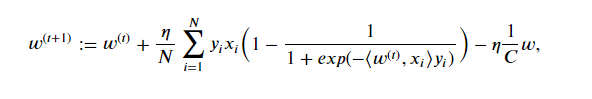

In [543]:
from sklearn import datasets
from sklearn import metrics

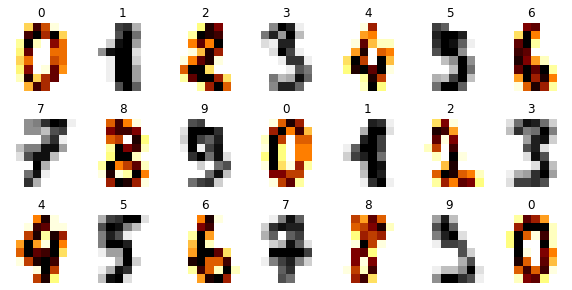

In [544]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [545]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [546]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [547]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [548]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [549]:
lr_clf.fit(X_train, y_train)

In [550]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [551]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [552]:
model = CustomLogisticRegression()

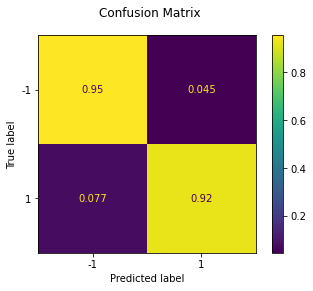

Wall time: 23.5 s


In [553]:
%%time
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [554]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [555]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [556]:
def lnplt(model):
    iter_count = np.linspace(0, len(model.loss_history), 0+len(model.loss_history))
    sns.lineplot(x=list(iter_count), y=list(model.loss_history))

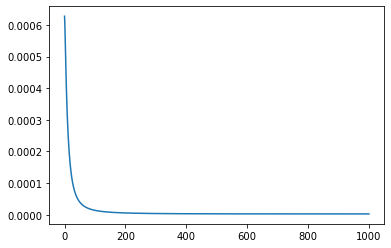

In [557]:
lnplt(model)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [558]:
ETA = [0.0007, 0.001, 0.002]
ETA

[0.0007, 0.001, 0.002]

Wall time: 1min 8s


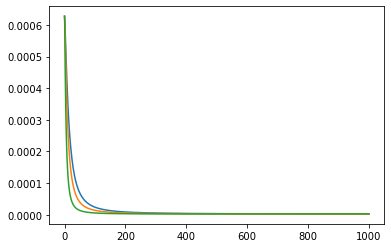

In [559]:
%%time
for eta in ETA:
    model = CustomLogisticRegression(eta = eta)
    model.fit(X_train, y_train)
    lnplt(model)

### Your thought:

Как видим из гарфиков, что при увеличении/уменьшении переменной learning rate (eta) увеличивается/уменьшается скорость сходимости(спуска) к глобальному минимуму функции.Очень большие значения могут ускорить спуск, но перескочить минимум, что недопустимо, в свою очередь очень маленькие значения заставят произвести большое количество итераций спуска для достаточной точности, что так же плохо. Поэтому learning rate отбирают оптимально между большими и маленькими значениями. 

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [560]:
C_values = np.linspace(0, 5, 6)
C_values

array([0., 1., 2., 3., 4., 5.])

In [561]:
%%time
for c in C_values:
    model = CustomLogisticRegression(C = c)
    model.fit(X_train, y_train)
    print('For ', c, ' coefficient of regularization: ',  metrics.accuracy_score(y_pred=model.predict(X_train),
                                                                                 y_true=y_train), 
                                                          metrics.accuracy_score(y_pred=model.predict(X_test),
                                                                                 y_true=y_test))

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_9732/1877817997.py:64: RuntimeWarning: divide by zero encountered in true_divide
  delta = -np.sum(np.array(matrix), axis=0) / X_ext.shape[0] + self.weights_/self.C
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_9732/1877817997.py:74: RuntimeWarning: invalid value encountered in add
  previous_weights = self.weights_ + self.eta * delta
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_9732/1877817997.py:62: RuntimeWarning: invalid value encountered in matmul
  string =y[j] * X_ext[j, :] * (1 - 1 / (1+np.exp(-X_ext[j, ::] @ self.weights_ * y[j])))


For  0.0  coefficient of regularization:  0.4968684759916493 0.49166666666666664
For  1.0  coefficient of regularization:  0.9109255393180237 0.9388888888888889
For  2.0  coefficient of regularization:  0.9137091162143354 0.9444444444444444
For  3.0  coefficient of regularization:  0.9151009046624913 0.9444444444444444
For  4.0  coefficient of regularization:  0.9151009046624913 0.9444444444444444
For  5.0  coefficient of regularization:  0.9151009046624913 0.9444444444444444
Wall time: 3min 4s


### < your thoughts >

Как видим с ростом коэффициента регуляризации качество модели немного улучшилось. Если же регуляризация отсутствует метрики качества ужасны.

**(0.5 points)** Compare zero initialization and random initialization. 

In [563]:
%%time

default_model = CustomLogisticRegression(zero_init=False)
default_model.fit(X_train, y_train)
print('default model: ', metrics.accuracy_score(y_pred=default_model.predict(X_train), y_true=y_train), 
metrics.accuracy_score(y_pred=default_model.predict(X_test), y_true=y_test))

manual_model = CustomLogisticRegression(zero_init=True)
manual_model.fit(X_train, y_train)
print('manual model: ', metrics.accuracy_score(y_pred=manual_model.predict(X_train), y_true=y_train), 
metrics.accuracy_score(y_pred=manual_model.predict(X_test), y_true=y_test))

default model:  0.9109255393180237 0.9388888888888889
manual model:  0.9116214335421016 0.9388888888888889
Wall time: 49 s


In [566]:
print(default_model.weights_, manual_model.weights_, sep='\n') 

[-5.61915300e-04  2.54962444e-03  8.05168031e-04  2.64461817e-02
  5.04182465e-02  1.17457428e-02  1.03371194e-01  6.70463240e-02
  3.05175128e-03  6.58716972e-04 -1.89209111e-02 -5.64187669e-03
  1.62034296e-02  4.13576770e-02  3.88461301e-02 -2.00441568e-03
 -5.01388119e-03  4.67910379e-04 -8.66514925e-03 -6.41268617e-02
  2.05081900e-02  4.95282731e-02 -3.86565158e-02 -4.52825268e-02
 -6.46592187e-03  1.68102605e-03 -5.05357780e-03  8.64519669e-03
  8.46281755e-02  5.24000240e-02  1.32485623e-02 -2.32947459e-02
 -2.90703266e-03  2.53927936e-03 -5.18311032e-02 -6.10504115e-04
  6.59376294e-06 -1.81912986e-02  4.38760219e-02  2.39251629e-02
 -2.13807403e-03 -2.44218976e-04 -2.90278222e-02 -1.38402384e-01
 -8.51915438e-02 -2.81055457e-03 -1.37131401e-03  2.29437756e-02
 -2.55685254e-03 -2.11156633e-03 -7.06938258e-03 -7.12772594e-02
 -4.66872991e-03 -2.31396520e-02 -6.36624557e-02 -1.43926681e-02
  9.70751318e-03 -1.77487242e-03 -4.08647644e-03  2.78884652e-02
  1.58824986e-02 -5.73985

### < your thoughts >

Как видим при нулевой инициализации некоторые весы остались нулевыми, в то время при случайной инициализации все веса ненулевые, причём некоторые веса значительно отличаются от от весов при  нулевой инициализации.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [513]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=10, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        distance_matrix = list()
        for i in X:
            line = list()
            for j in Y:
                distance = np.sqrt(np.sum((i - j) ** 2))
                #        np.linalg.norm(i, j)#np.sqrt((i[0] - j[0]) ** 2 + (i[1] - j[1]) ** 2)
                line.append(distance)
            distance_matrix.append(line)
        return np.array(distance_matrix)

    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        vector = list()
        for i in self.classes_:
            temp_sum = 0
            index_list = list()
            counter = 0
            for j in y:
                if j == i:
                    index_list.append(counter)
                counter += 1
            for k in index_list:
                temp_sum += weights[k]
            vector.append(temp_sum)
        return vector
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """

        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            final_proba = []

            if self.weights == 'distance':
                weights = 1 / (P + self.eps)
                weights_of_points = np.zeros_like(P)

                for i in range(weights.shape[0]):
                    for j in np.argsort(-weights[i])[0:self.n_neighbors]:
                        weights_of_points[i][j] = weights[i][j]

                class_proba = np.asarray([self.get_class_weights(self.y, weights_of_points[i]) for i in range(weights_of_points.shape[0])])
                for i in range(class_proba.shape[0]):
                    final_proba.append([class_proba[i][j] / np.sum(class_proba[i]) for j in range(class_proba.shape[1])])
                return np.asarray(final_proba)

            if self.weights == 'uniform':
                weights_of_points = np.zeros_like(P)
                
                for i in range(P.shape[0]):
                    for j in np.argsort(P[i])[0:self.n_neighbors]:
                        weights_of_points[i][j] = 1
                class_proba = np.asarray([self.get_class_weights(self.y, weights_of_points[i]) \
                                          for i in range(weights_of_points.shape[0])])

                for i in range(class_proba.shape[0]):
                    final_proba.append([class_proba[i][j] / np.sum(class_proba[i]) for j in range(class_proba.shape[1])])
                return np.asarray(final_proba)

        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        result = list()
        for i in self.predict_proba(X):
            if 1 in i:
                result.append(list(i).index(1))
            else: 
                max_prob = 0
                for j in i:
                    if j > max_prob:
                        max_prob = j
                result.append(list(i).index(max_prob))
        return result

In [514]:
model_knn = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [515]:
model_knn.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]]))

array([[0.70710678, 1.41421356],
       [0.70710678, 1.        ]])

In [516]:
assert np.allclose(model_knn.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [517]:
model_knn .classes_ = ['one', 'two', 'three']
assert np.allclose(model_knn .get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

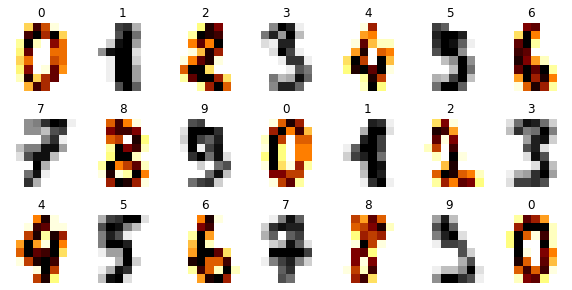

In [518]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [519]:
model_knn .fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [520]:
das = model_knn.predict(X_test)

In [521]:
len(das)

360

In [522]:
assert np.allclose(model_knn .predict_proba(X_test), knn.predict_proba(X_test))

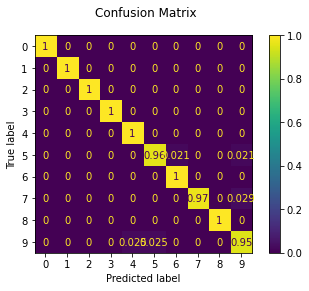

In [523]:
train_acc, test_acc = fit_evaluate(model_knn , X_train, y_train, X_test, y_test)

In [524]:
print(train_acc, test_acc) 

1.0 0.9861111111111112


In [525]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Модель путает цифры 5, 7 и 9 с 4, 5, 6, 7 и 9. Скорей всего в датасетах они изображены слишком криво или плохо таким образом, что больше похожи на другие цифры, нарисованные нормально и хорошо.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [531]:
N_NEIGHBORS = [1, 5, 10, 15]

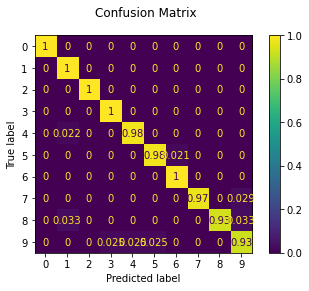

For n  1 :  (1.0, 0.9777777777777777)


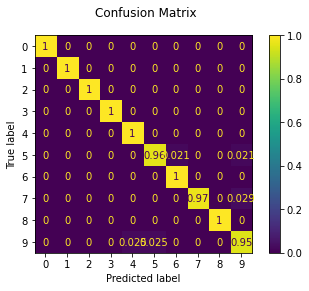

For n  5 :  (1.0, 0.9861111111111112)


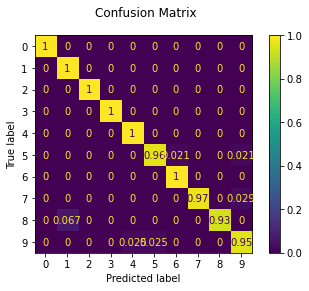

For n  10 :  (1.0, 0.9805555555555555)


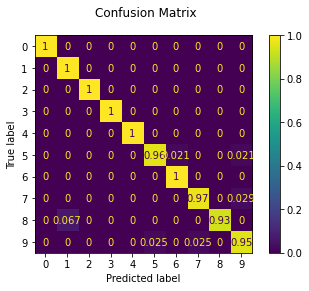

For n  15 :  (1.0, 0.9805555555555555)
Wall time: 3min 17s


In [535]:
%%time
for n_neighbors in N_NEIGHBORS:
    model_knn = CustomKNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    model_knn.fit(X_train, y_train)
    print('For n ', n_neighbors, ': ', fit_evaluate(model_knn , X_train, y_train, X_test, y_test))

Наилучший покатель скора получился при n=5. Скорей всего это связано с тем, что при n=1 модели недостаточно информации по 1 соседу, чтобы более точно классифицировать объект. В свою очерередь n=10, n=15 дают модели свободу выделять слишком много разных гипотез на основе большого количества соседей, что скорей всего её путает.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

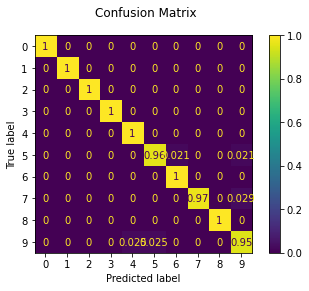

uniform (0.9895615866388309, 0.9861111111111112)


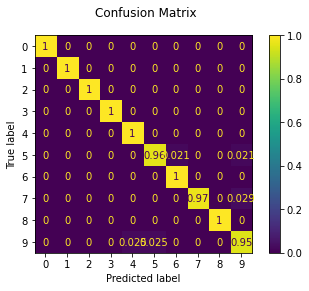

distance (1.0, 0.9861111111111112)
Wall time: 1min 41s


In [538]:
%%time
model_knn_uniform = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
model_knn_distance = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
model_knn_uniform.fit(X_train, y_train)
model_knn_distance.fit(X_train, y_train)
print('uniform', fit_evaluate(model_knn_uniform , X_train, y_train, X_test, y_test))
print('distance', fit_evaluate(model_knn_distance , X_train, y_train, X_test, y_test))

For example, uniform means that all neighbors get an equally weighted “vote” about an observation's class while weights = 'distance' would tell the learner to weigh each observation's “vote” by its distance from the observation we are classifying.
Я нарисую пример, когда учёт расстояние до точки может навредить (когда у нас есть серьёзные выбросы, которые могут неправильно классифицировтаь точку):
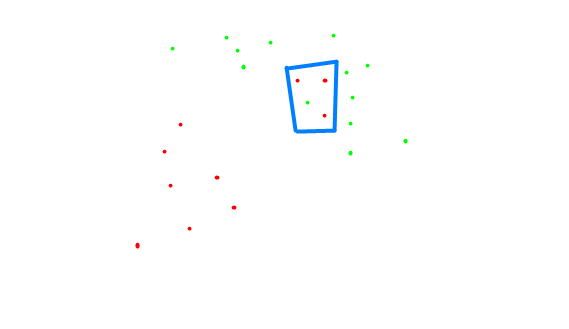
В таком случае, если мы будем использовать distance, мы неправильно классифицируем зелёную точку, так как она находится ближе к красным точкам, но если мы будем использовать uniform и n=10, то она классифицируется правильно.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Так как у нас цифры заданы в виде матрцы весов, то возможно лучше будет использовать более квадратную метрику, такую как расстояние шахматной доски(Чебышева).
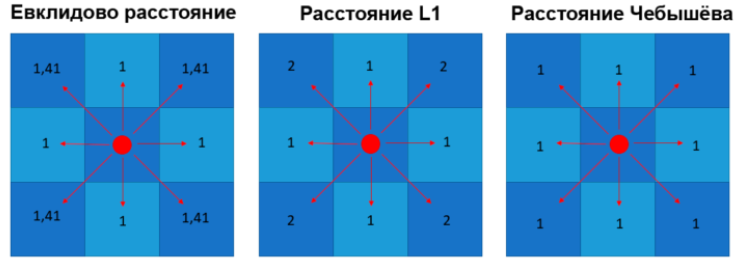

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Задача нахождения кратчайшего маршрута, для которого удобно использовать для модели knn функцию расстояния L1.
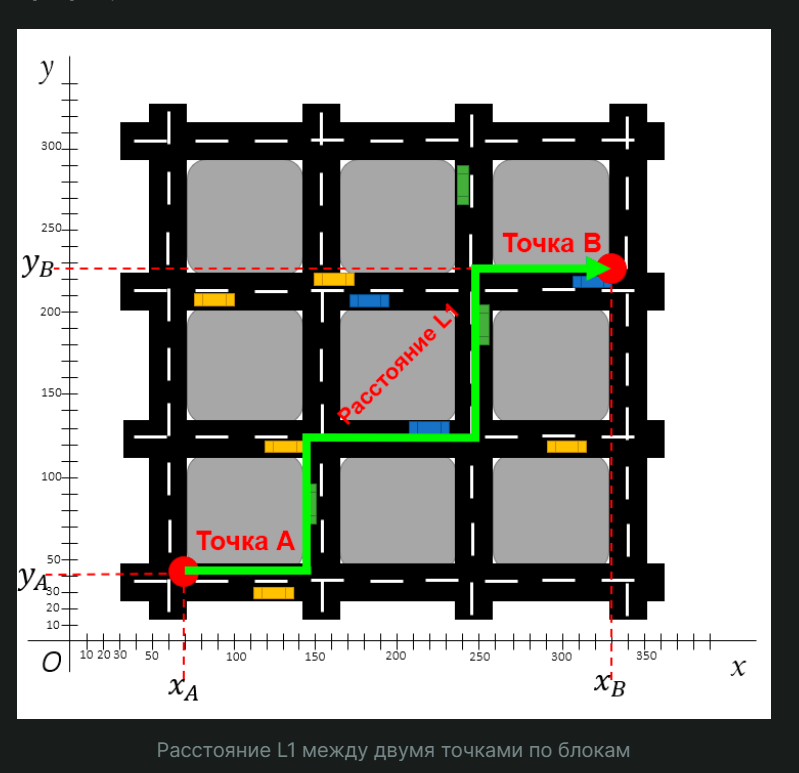

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [858]:
PATH = "./data/"

In [859]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [860]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [861]:
print(data[data.Sex == 'male'].Sex.count(),data[data.Sex == 'female'].Sex.count())

56114 43886


<AxesSubplot:xlabel='Sex'>

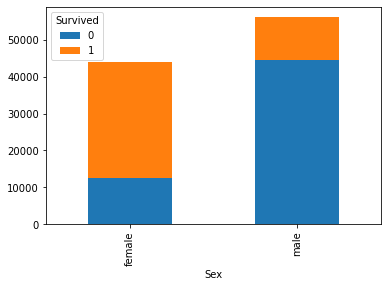

In [862]:
data.reset_index().pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(kind='bar', stacked=True)

Как видим большинство женщин выжило, а мужчин нет, используем это для улучшения предсказания модели.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:>

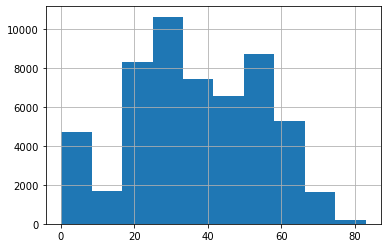

In [863]:
data[data.Survived == 0].Age.hist()

<AxesSubplot:>

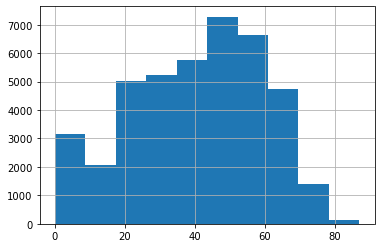

In [864]:
data[data.Survived == 1].Age.hist()

In [865]:
print('Deceased passengers: \n', data[data.Survived == 0].Age.describe(),
      '\n\nSurvived passengers: \n', data[data.Survived == 1].Age.describe())

Deceased passengers: 
 count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64 

Survived passengers: 
 count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64


### Your thoughts:

Как видно из графиков, для параметра выживаемости значительно преобладают возраста детей юношеского возраста (они были в приоритете спасения) и преклонного возраста (скорей всего зажиточные люди, для которых тоже был какой-то приоритет в спасении).

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

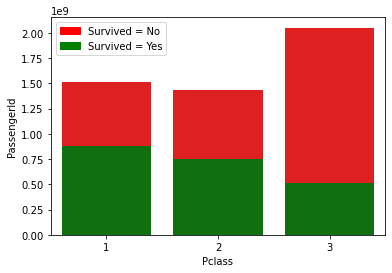

In [866]:
import matplotlib.patches as mpatches
temp_data = data.reset_index()
total = temp_data.groupby('Pclass')['PassengerId'].sum().reset_index()
bar1 = sns.barplot(x='Pclass',  y='PassengerId', data=total, color='red')
survived = temp_data[temp_data.Survived==1]
bar2 = sns.barplot(x='Pclass',  y='PassengerId', data=survived, estimator=sum, ci=None,  color='green')
top_bar = mpatches.Patch(color='red', label='Survived = No')
bottom_bar = mpatches.Patch(color='green', label='Survived = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

Как видим 1ый класс является самым безопасным, а также 2ой не сильно уступает 1ому.

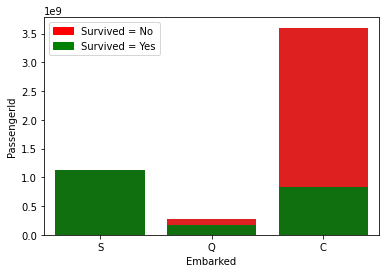

In [867]:
total = temp_data.groupby('Embarked')['PassengerId'].sum().reset_index()
bar1 = sns.barplot(x='Embarked',  y='PassengerId', data=total, color='red')
survived = temp_data[temp_data.Survived==1]
bar2 = sns.barplot(x='Embarked',  y='PassengerId', data=survived, estimator=sum, ci=None,  color='green')
top_bar = mpatches.Patch(color='red', label='Survived = No')
bottom_bar = mpatches.Patch(color='green', label='Survived = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

Text(0.5, 1.0, 'Relationship between Embarked and Survival')

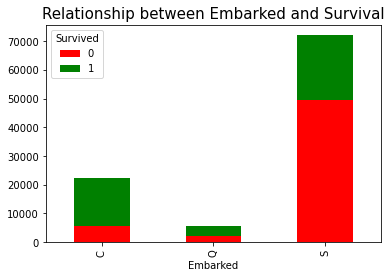

In [868]:
df = data.groupby(['Embarked', 'Survived'])['Embarked'].count().unstack('Survived')
df[[0, 1]].plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Relationship between Embarked and Survival', fontsize=15)

Как видно из графика очень много пассажиров было размещено на корабле на порте S и много пассажиров с этого порта и погибло, с порта C довольно большое количество выжило(возможно с порта C была посадка более влиятельных пассажиров, а на порту S наоборот - менее влиятельных).

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [869]:
data.isna().sum() / data.isna().count() * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Количество пропущенных значений в столбце Cabin значительно, но мы не можем заполнить их значениями основываясь на известных данных. Хоть пропущенных значений Ticket немного, но обработать мы их так же не можем, по аналогичной ситуации с Cabin. Пропущенные значения Age мы можем обработать. Так как скорее всего значения Age и Fare будут коррелировать с другими переменными, такими как Pclass (что вполне лоигчно предположить, ведь, чем старе человек, тем скорее всего он будет состоятельнее и позволет себе более высокий по статусу класс), тогда произведём замену пропущенных значений Age и Fare на их средние значения по классам; пропущенным значениям Embarked присвоим порт в котором село больше всего людей.

Преимущество метода заполнения значений в соответвии с классом вероятнее всего правдиво отражает зависимость между данными, но всё-таки есть недостаток: реальные данные мы не знаем, а только заполняем их приблизительно правдоподобными, что конечно неплохо, но может ухудшить модель, если реальные данные вдруг окажутся не такими, какими мы их предполагали.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [870]:

# Age
data.loc[(data['Pclass'] == 1) & (data['Age'].isna()), 'Age'] = data[data.Pclass == 1].Age.median()
data.loc[(data['Pclass'] == 2) & (data['Age'].isna()), 'Age'] = data[data.Pclass == 2].Age.median()
data.loc[(data['Pclass'] == 3) & (data['Age'].isna()), 'Age'] = data[data.Pclass == 3].Age.median()
# Fare
data.loc[(data['Pclass'] == 1) & (data['Fare'].isna()), 'Fare'] = data[data.Pclass == 1].Fare.median()
data.loc[(data['Pclass'] == 2) & (data['Fare'].isna()), 'Fare'] = data[data.Pclass == 2].Fare.median()
data.loc[(data['Pclass'] == 3) & (data['Fare'].isna()), 'Fare'] = data[data.Pclass == 3].Fare.median()
# Embarked
data.loc[data['Embarked'].isna(), 'Embarked'] = 'S'
# Sex
data.loc[data['Sex'] == 'female', 'Sex'] = 0
data.loc[data['Sex'] == 'male', 'Sex'] = 1
# Cabin 67866 32134
# RUN ONLY ONCE!!!
data.loc[~(data.Cabin.isna()), 'Cabin'] = 1
data.loc[data.Cabin.isna(), 'Cabin'] = 0
#Embarked
data.loc[data['Embarked'] == 'S', 'Embarked'] = 1
data.loc[data['Embarked'] == 'Q', 'Embarked'] = 2
data.loc[data['Embarked'] == 'C', 'Embarked'] = 3


In [871]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",1,47.00,2,0,209245,27.14,1,1
1,0,3,"Bryan, Drew",1,30.00,0,0,27323,13.35,0,1
2,0,3,"Owens, Kenneth",1,0.33,1,2,CA 457703,71.29,0,1
3,0,3,"Kramer, James",1,19.00,0,0,A. 10866,13.04,0,1
4,1,3,"Bond, Michael",1,25.00,0,0,427635,7.76,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",0,62.00,0,0,PC 15008,14.86,1,3
99996,0,2,"Brown, Herman",1,66.00,0,0,13273,11.15,0,1
99997,0,3,"Childress, Charles",1,37.00,0,0,NaN,9.95,0,1


In [872]:
X = data.drop(['Ticket', 'Survived', 'Name'], axis=1)
y = data['Survived']

In [873]:
#split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [874]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [875]:
# # Normalizing continuous variables

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range = (0,1))

# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [876]:
from sklearn.model_selection import cross_val_score

In [877]:
%%time
# knn with cross-validation
knn_clf = KNeighborsClassifier(n_neighbors=4)
#knn_clf.fit(X_train, y_train)
knn_scores = cross_val_score(knn_clf, X, y, cv=5)

Wall time: 12.9 s


In [878]:
# previous 0.72149 -> 0.745(normalized data)
knn_scores.mean()

0.7112700000000001

In [879]:
from sklearn.linear_model import LogisticRegression

In [880]:
%%time
log_clf = LogisticRegression(max_iter=5000)
log_clf.fit(X, y)
log_scores = cross_val_score(log_clf, X, y, cv=5)

Wall time: 12 s


In [881]:
# previous 0.75789 -> 0.7581(with cabin) -> 0.757(normalized)
# max 0.7581
log_scores.mean()

0.76732

In [882]:
result_score = (knn_scores.mean() + log_scores.mean()) / 2
result_score

0.739295

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [883]:
#your code
predictor_cols = X.columns

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [884]:
# Read the test data
#test = pd.read_csv('../input/test.csv')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
#test = preprocessing_data(test)

In [885]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C


In [886]:
test.loc[(test['Pclass'] == 1) & (test['Age'].isna()), 'Age'] = test[test.Pclass == 1].Age.median()
test.loc[(test['Pclass'] == 2) & (test['Age'].isna()), 'Age'] = test[test.Pclass == 2].Age.median()
test.loc[(test['Pclass'] == 3) & (test['Age'].isna()), 'Age'] = test[test.Pclass == 3].Age.median()
# Fare
test.loc[(test['Pclass'] == 1) & (test['Fare'].isna()), 'Fare'] = test[test.Pclass == 1].Fare.median()
test.loc[(test['Pclass'] == 2) & (test['Fare'].isna()), 'Fare'] = test[test.Pclass == 2].Fare.median()
test.loc[(test['Pclass'] == 3) & (test['Fare'].isna()), 'Fare'] = test[test.Pclass == 3].Fare.median()
# Embarked
test.loc[test['Embarked'].isna(), 'Embarked'] = 'S'
# Sex
test.loc[test['Sex'] == 'female', 'Sex'] = 0
test.loc[test['Sex'] == 'male', 'Sex'] = 1
# Cabin 67866 32134
# RUN ONLY ONCE!!!
test.loc[~(test.Cabin.isna()), 'Cabin'] = 1
test.loc[test.Cabin.isna(), 'Cabin'] = 0
#Embarked
test.loc[test['Embarked'] == 'S', 'Embarked'] = 1
test.loc[test['Embarked'] == 'Q', 'Embarked'] = 2
test.loc[test['Embarked'] == 'C', 'Embarked'] = 3

In [887]:
test_pred = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [888]:
test_pred

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,19.0,0,0,63.01,0,1
1,3,0,53.0,0,0,5.81,0,1
2,1,0,19.0,0,0,38.91,1,3
3,2,1,25.0,0,0,12.93,0,1
4,1,0,17.0,0,2,26.89,1,3
...,...,...,...,...,...,...,...,...
99995,3,0,27.0,0,0,10.12,0,2
99996,1,1,59.0,1,0,68.31,0,1
99997,3,1,47.0,0,0,10.87,0,1
99998,1,0,49.0,1,2,29.68,1,3


In [889]:
# Treat the test data in the same way as training data. In this case, pull same columns.
test_X = test_pred
# Use the model to make predictions
predicted_survives = log_clf.predict(test_X)
# We will look at the predicted prices to ensure we have something sensible.
print(predicted_survives)

[0 1 1 ... 0 1 1]


In [890]:
my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predicted_survives})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

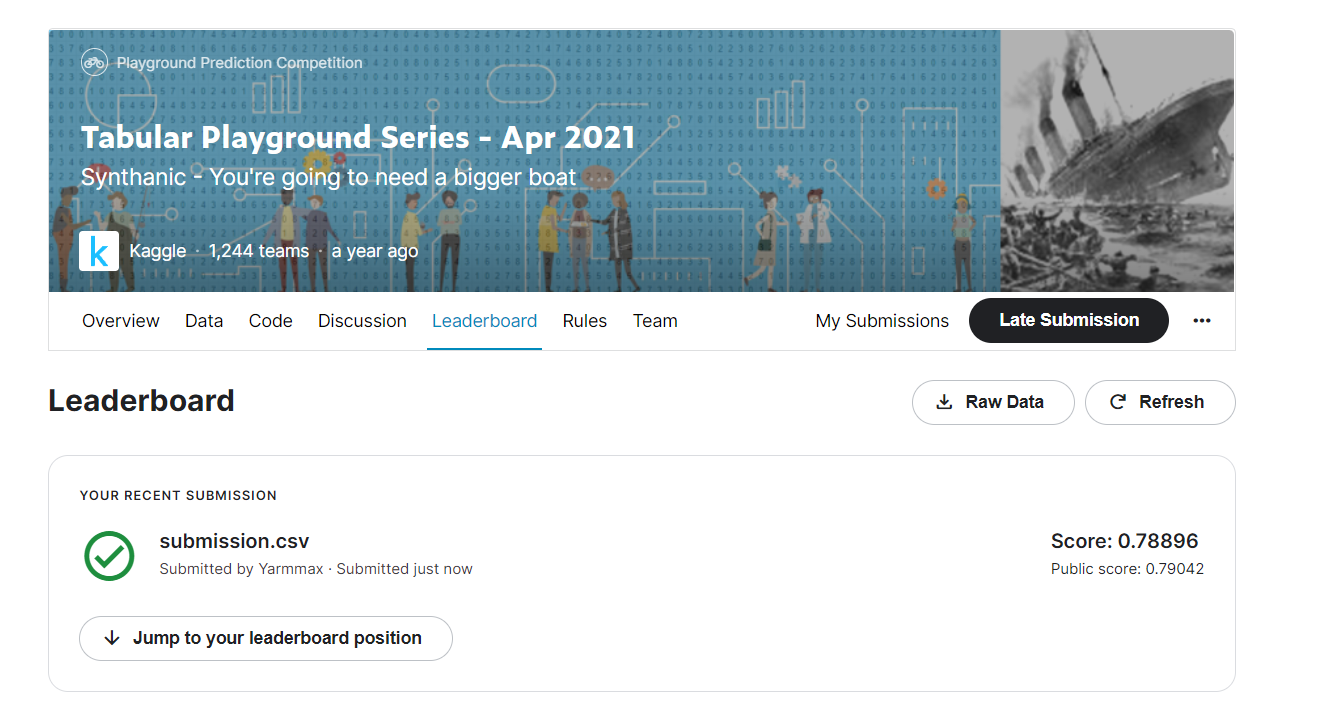